In [1]:
import torch.nn as nn
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from transformer import SpaceTimeFormer
import torch
import datetime as dt

C:\Users\Haris\anaconda3\envs\Transformers_Project\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def download_data(TICKER, START_DATE, END_DATE):
    data = yf.download(TICKER, start= START_DATE, end = END_DATE)
    data = data['Close']
    return data

date_start = '2021-01-03'
date_end = '2022-12-03'

#Stocks
ticker = {
    'VIX': ['^VIX','Volatility_Index'],
    'UnitedHealth Group': ['UNH', 'Health Care'],
    'Goldman Sachs': ['GS', 'Financials'],
    'Home Depot': ['HD', 'Consumer Discretionary'],
    'Amgen': ['AMGN', 'Helth Care'],
    'McDonalds': ['MCD','Consumer Discretionary'],
    'Microsoft': ['MSFT', 'Information Technology'],
    'Caterpillar': ['CAT','Industrials'],
    'Honeywell': ['HON', 'Industrials'],
    'Visa':['V','Information Technology'],
    'Boeing':['BA', 'Industrials'],
    'Travelers Companies': ['TRV','Financials'],
    'Johnson&Johnson': ['JNJ', 'Health Care'],
    'Chevron': ['CVX', 'Energy'],
    'American Express':['AXP', 'Financials'],
    'Procter&Gamble': ['PG', 'Consumer Staples'],
    'IBM':['IBM', 'Information Technology'],
    'Walmart': ['WMT', 'Consumer Staples'],
    'Apple':['AAPL','Information Technology'],
    'Salesforce': ['CRM', 'Information Technology'],
    'JP Morgan': ['JPM','Financials'],
    '3M': ['MMM', 'Industrials'],
    'Merck & Co': ['MRK', 'Health Care'],
    'Nike': ['NKE', 'Consumer Discretionary'],
    'Walt Disney': ['DIS', 'Communication Services'],
    'Coca Cola':['KO','Consumer Staples'],
    'Dow Inc':['DOW','Materials'],
    'Cisco':['CSCO','Information Technology'],
    'Walgreens': ['WBA', 'Consumer Staples'],
    'Verizon': ['VZ', 'Communication Services'],
    'Intel':['INTC', 'Information Technology'],
    'DowJones': ['^DJI', 'Index'],
}

#load data
df = pd.concat([download_data(name[0], date_start, date_end) for name in ticker.values()], axis=1)

#rename columns
df.set_axis([name for name in ticker.keys()], axis=1, copy=True)

#calculate returns
df = df.pct_change(1)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()
datetime = df.index
df = df.to_numpy().transpose()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [3]:
sectors_list = []
sectors = []
for sector in ticker.values():
    if sector[1] not in sectors:
        sectors.append(sector[1])
    if sector[1] != 'Index':
        sectors_list.append(sectors.index(sector[1])) 

In [4]:
sequence_souce = df[:-1, :]
sequence_target = df[-1, :].reshape(1,-1)

In [5]:
split = 0.7
pred_window = 1
seq_length = 10
datetime_train = datetime[:int(split*len(datetime))]
datetime_test = datetime[int(split*len(datetime)):]
sequence_source_train = sequence_souce[:, :int(np.shape(sequence_souce)[1]*split)]
sequence_source_test = sequence_souce[:, int(np.shape(sequence_souce)[1]*split):]
sequence_target_train = sequence_target[:, :int(np.shape(sequence_target)[1]*split)]
sequence_target_test = sequence_target[:, int(np.shape(sequence_target)[1]*split):]

In [6]:
## Scaling ###
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(np.transpose(sequence_source_train))
sequence_source_train = np.transpose(scaler.transform(np.transpose(sequence_source_train)))
sequence_source_test = np.transpose(scaler.transform(np.transpose(sequence_source_test)))

In [7]:
model = SpaceTimeFormer(pred_offset = pred_window,
                        input_size = 31,
                        output_size = 1,
                        seq_length = seq_length,
                        sectors_list = sectors_list,
                        datetime_index = datetime,
                        embedding_size_time = 10,
                        embedding_size_variable = 10,
                        embedding_size_sector = 0)

{'Train': 2.206331723405478e-07, 'Evaluation': 2.570294891484082e-07}

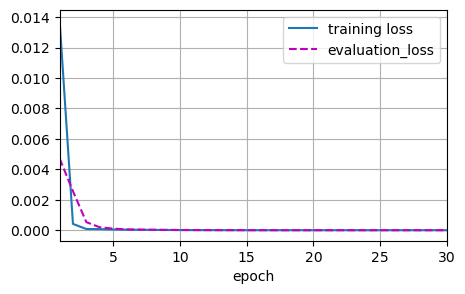

In [8]:
model.start_training(source = sequence_source_train,
                     target = sequence_target_train,
                     loss = nn.MSELoss(),
                     metric = nn.MSELoss(),
                     epochs = 30,
                     batch_size = 64,
                     learning_rate = 1e-3,
                     standardize = False,
                     verbose = False,
                     plot = True)
model.scores

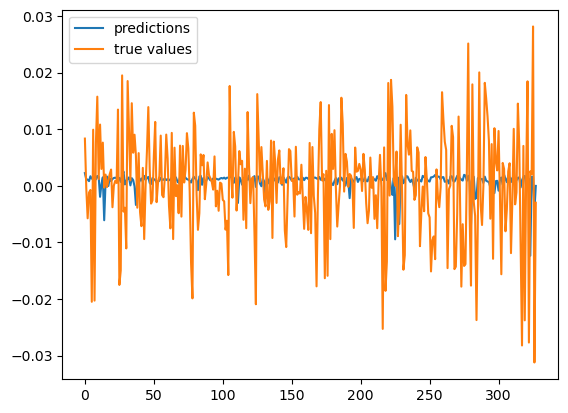

In [9]:
source = sequence_source_train
target = sequence_target_train

l = np.shape(sequence_source_train)[1]
y_hat = np.zeros((1,l))
y = target

src_idx_1, src_idx_2 = 0, 0
trg_idx_1, trg_idx_2 = 1, 1

while trg_idx_2 < l:
    src_idx_2 = src_idx_1 + seq_length
    trg_idx_2 = trg_idx_1 + seq_length + pred_window - 1
    
    src = source[:, src_idx_1:src_idx_2]
    trg_stub = target[:, trg_idx_1:trg_idx_2-pred_window]
    y_hat[0, trg_idx_2-pred_window:trg_idx_2] = model.predict(src, trg_stub, False)
    
    src_idx_1 += pred_window
    trg_idx_1 += pred_window

plt.plot(y_hat[0,seq_length:], label = 'predictions')
plt.plot(y[0,seq_length:],label = 'true values')
plt.legend()
plt.show()

In [10]:
hit_rate = np.sum((np.where(y_hat>0,np.where(y>0,1,0),0)+np.where(y_hat<=0,np.where(y<=0,1,0),0)))/np.shape(y)[1]
hit_rate

0.5325443786982249

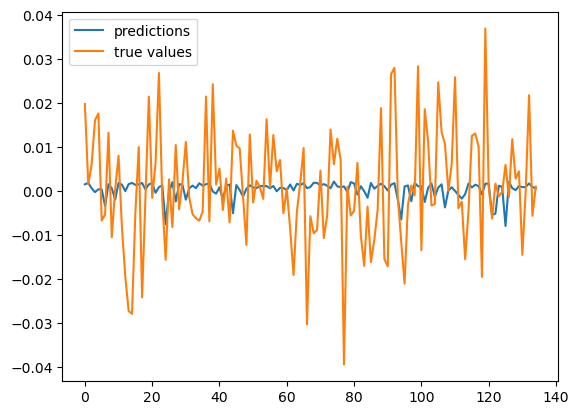

In [11]:
source = sequence_source_test
target = sequence_target_test

l = np.shape(sequence_source_test)[1]
y_hat = np.zeros((1,l))
y = target

src_idx_1, src_idx_2 = 0, 0
trg_idx_1, trg_idx_2 = 1, 1

while trg_idx_2 < l:
    src_idx_2 = src_idx_1 + seq_length
    trg_idx_2 = trg_idx_1 + seq_length + pred_window - 1
    
    src = source[:, src_idx_1:src_idx_2]
    trg_stub = target[:, trg_idx_1:trg_idx_2-pred_window]
    y_hat[0, trg_idx_2-pred_window:trg_idx_2] = model.predict(src, trg_stub, False)
    
    src_idx_1 += pred_window
    trg_idx_1 += pred_window

plt.plot(y_hat[0,seq_length:], label = 'predictions')
plt.plot(y[0,seq_length:],label = 'true values')
plt.legend()
plt.show()

In [12]:
np.sum((np.where(y_hat>0,np.where(y>0,1,0),0)+np.where(y_hat<=0,np.where(y<=0,1,0),0)))/np.shape(y)[1]

0.496551724137931